In [1]:
import torch
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import os

In [2]:
path = "data_use_dirichlet/"

In [3]:
if os.path.exists(path) == False:
  os.mkdir(path)
  raise Exception(f"Upload data first at {path}")

In [4]:
# set wavenumber and wavelength
k = 2.0 * np.pi
lamb =  2.0 * np.pi / k

In [5]:
# domain [la,lb]
la = -12.0 * lamb
lb = 12.0 * lamb

In [6]:
# define the mesh for calculation
N_obs = 240
h_obs = (lb - la) / N_obs
mesh_obs = np.linspace(la, lb, (N_obs + 1))

In [7]:
mesh_mid_obs = np.zeros(N_obs + 1)

In [8]:
mesh_mid_obs[0] = la

In [9]:
for od in range(N_obs):
    mesh_mid_obs[od + 1] = (mesh_obs[od] + mesh_obs[od+1])/2.0

In [10]:
# transform numpy mesh to torch mesh
x_mid_obs = torch.tensor(mesh_mid_obs, dtype = torch.float32, requires_grad = True)
x_mesh_obs = torch.tensor(mesh_obs, dtype = torch.float32, requires_grad = True)

In [11]:
# mesh point input for the trunk network
x_tensor = x_mid_obs[1:]
x_tensors = x_tensor.detach()

In [12]:
# surface height range
hmax = 0.2 * lamb
hmin = -0.2 * lamb

In [13]:
# load data
data1 = torch.load(path+'data1.pt')
data2 = torch.load(path+'data2.pt')
data3 = torch.load(path+'data3.pt')
data4 = torch.load(path+'data4.pt')
data5 = torch.load(path+'data5.pt')
data6 = torch.load(path+'data6.pt')
data7 = torch.load(path+'data7.pt')
data8 = torch.load(path+'data8.pt')
data9 = torch.load(path+'data9.pt')
data10 = torch.load(path+'data10.pt')
data11 = torch.load(path+'data11.pt')
data12 = torch.load(path+'data12.pt')
data13 = torch.load(path+'data13.pt')
data14 = torch.load(path+'data14.pt')
data15 = torch.load(path+'data15.pt')
data16 = torch.load(path+'data16.pt')
data17 = torch.load(path+'data17.pt')
data18 = torch.load(path+'data18.pt')
data19 = torch.load(path+'data19.pt')
data20 = torch.load(path+'data20.pt')

In [14]:
data_train = data1 + data2 + data3 + data4 + data5 + data6 + data7 + data8 + data9 + data10 \
+ data11 + data12 + data13 +data14 + data15 + data16 + data17 + data18 + data19 + data20

In [15]:
size_data = len(data_train)
print('total number of data = ', size_data)

total number of data =  20000


In [16]:
# put surface height, scattered data, and measurement height in arrays
hei_array = []
phis_array = []
zz_array = []

In [17]:
for i in range(size_data):
    hei_array.append(data_train[i][0])
    phis_array.append(data_train[i][1])
    zz_array.append(data_train[i][2])

In [18]:
# stack the data in one tensor
hei_tensors = torch.stack(hei_array).detach()
phis_tensors = torch.stack(phis_array).detach()
phis_real_tensors = torch.real(phis_tensors)
phis_imag_tensors = torch.imag(phis_tensors)
zz_tensors = torch.stack(zz_array).detach()

In [19]:
# note that the normalzation range is [-0.5,0.5]
def normalize_tensor(input_tensor):

    min_val = torch.min(input_tensor)
    max_val = torch.max(input_tensor)
    normalized_tensor = (input_tensor - min_val) / (max_val - min_val) - 0.5

    return normalized_tensor

In [20]:
# normalization of data
normalized_hei_tensors = normalize_tensor(hei_tensors)
normalized_phis_real_tensors = normalize_tensor(phis_real_tensors)
normalized_phis_imag_tensors = normalize_tensor(phis_imag_tensors)
normalized_x_tensors = normalize_tensor(x_tensors)
normalized_zz_tensors = normalize_tensor(zz_tensors)

In [21]:
# inverse normalization of data, used for plotting original surface height
def inverse_normalize_tensor(normalized_tensor, original_max, original_min):

    return (normalized_tensor + 0.5) * (original_max - original_min) + original_min

structure for a uniform feed-forward neural network

In [22]:
class FNN(nn.Module):

    # input_size: the size of input tensor
    # output_size: size of output tensor
    # hidden_layers: number of hidden layers
    # hidden_neurons: number of hidden neurons per hidden layer
    # activation: activation function

    def __init__(self, input_size, output_size, hidden_layers, hidden_neurons, activation):

        super(FNN, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_layers = hidden_layers
        self.hidden_neurons = hidden_neurons
        self.activation = activation

        self.input_layer = nn.Linear(input_size, hidden_neurons)
        self.hidden_layers_list = nn.ModuleList()
        for _ in range(hidden_layers - 1):
            self.hidden_layers_list.append(nn.Linear(hidden_neurons, hidden_neurons))
        self.output_layer = nn.Linear(hidden_neurons, output_size)

    def forward(self, x):

        x = self.activation(self.input_layer(x))

        for hidden_layer in self.hidden_layers_list:
            x = self.activation(hidden_layer(x))

        x = self.activation(self.output_layer(x))

        return x
'''
# Reference CNN implementation for branch2.
# Minimises loss upto 9e-4 with 15000 epochs.
# Alternatively, reaches loss to the order of 6e-3 in 2400 epochs.
# However, DeepONet has 134154 learnable parameters (Almost double that of FNN).
# Serves as good benchmark for finetuning CNN architecture.
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = torch.nn.Tanh()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv1d(
                in_channels = 1,
                out_channels = 4,
                kernel_size = 11, # 7,
                stride = 1,
                padding = 2,
            ),
            torch.nn.BatchNorm1d(4),
            torch.nn.Tanh(), # torch.nn.ReLU(),
            torch.nn.MaxPool1d(3),
        )

        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv1d(
                in_channels = 4,
                out_channels = 8,
                kernel_size = 5,
                stride = 1,
                padding = 2,
            ),
            torch.nn.BatchNorm1d(8),
            torch.nn.Tanh(), # torch.nn.ReLU(),
            torch.nn.MaxPool1d(3),
        )

        self.fnn1 = torch.nn.Linear(416, 234)
        self.fnn2 = torch.nn.Linear(234, 64)

    def forward(self, x):
        assert torch.isinf(x).any() != True
        x = self.conv1(x)
        assert torch.isinf(x).any() != True
        x = self.conv2(x)
        assert torch.isinf(x).any() != True
        x = x.view(x.size(0), -1)
        output = self.activation(self.fnn1(x))
        output = self.activation(self.fnn2(output))
        return output
'''

'\n# Reference CNN implementation for branch2.\n# Minimises loss upto 9e-4 with 15000 epochs.\n# Alternatively, reaches loss to the order of 6e-3 in 2400 epochs.\n# However, DeepONet has 134154 learnable parameters (Almost double that of FNN).\n# Serves as good benchmark for finetuning CNN architecture.\nclass CNN(nn.Module):\n    def __init__(self):\n        super().__init__()\n        self.activation = torch.nn.Tanh()\n        self.conv1 = torch.nn.Sequential(\n            torch.nn.Conv1d(\n                in_channels = 1,\n                out_channels = 4,\n                kernel_size = 11, # 7,\n                stride = 1,\n                padding = 2,\n            ),\n            torch.nn.BatchNorm1d(4),\n            torch.nn.Tanh(), # torch.nn.ReLU(),\n            torch.nn.MaxPool1d(3),\n        )\n\n        self.conv2 = torch.nn.Sequential(\n            torch.nn.Conv1d(\n                in_channels = 4,\n                out_channels = 8,\n                kernel_size = 5,\n      

In [23]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = torch.nn.Tanh()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv1d(
                in_channels = 1,
                out_channels = 4,
                kernel_size = 11, # 7,
                stride = 1,
                padding = 2,
            ),
            torch.nn.BatchNorm1d(4),
            torch.nn.Tanh(), # torch.nn.ReLU(),
            torch.nn.AvgPool1d(3), # torch.nn.MaxPool1d(3),
        )

        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv1d(
                in_channels = 4,
                out_channels = 8,
                kernel_size = 5,
                stride = 1,
                padding = 2,
            ),
            torch.nn.BatchNorm1d(8),
            torch.nn.Tanh(), # torch.nn.ReLU(),
            torch.nn.AvgPool1d(3), # torch.nn.MaxPool1d(3),
        )

        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv1d(
                in_channels = 8,
                out_channels = 8,
                kernel_size = 5,
                stride = 1,
                padding = 2,
            ),
            torch.nn.BatchNorm1d(8),
            torch.nn.Tanh(), # torch.nn.ReLU(),
            torch.nn.AvgPool1d(3), # torch.nn.MaxPool1d(3),
        )

        self.fnn1 = torch.nn.Linear(136, 64)
        self.fnn2 = torch.nn.Linear(64, 64)
        self.fnn3 = torch.nn.Linear(64, 64)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        output = self.activation(self.fnn1(x))
        output = self.activation(self.fnn2(output))
        output = self.activation(self.fnn3(output))
        return output

main structure of DeepONet with multiple inputs (two inputs)

In [24]:
class DeepONet(nn.Module):

    # this deeponet contains 2 branch nets and 1 trunk net
    # input_size_branch1: size of input tensor for branch net1
    # hidden_layers_branch1: number of hidden layers in branch net1
    # hidden_neurons_branch1: number of neurons per hidden layer in branch net1
    # input_size_branch2: size of input tensor for branch net2
    # hidden_layers_branch2: number of hidden layers in branch net2
    # hidden_neurons_branch2: number of neurons per hidden layer in branch net2
    # hidden_layers_trunk: number of hidden layers in trunk net
    # hidden_neurons_trunk: number of neurons per hidden layer in trunk net
    # inner_layer_siz: size of the inner layer, i.e. value of p
    # activation: activation function
    # size_bias: size of the output bias tensor

    def __init__(self, input_size_branch1, hidden_layers_branch1, hidden_neurons_branch1, \
                 input_size_branch2, hidden_layers_branch2, hidden_neurons_branch2, \
                 hidden_layers_trunk, hidden_neurons_trunk, \
                 inner_layer_size, activation, size_bias):

        super(DeepONet, self).__init__()
        self.branch1 = FNN(input_size_branch1, inner_layer_size, hidden_layers_branch1, \
                           hidden_neurons_branch1, activation)
        self.branch2 = CNN() # FNN(input_size_branch2, inner_layer_size, hidden_layers_branch2, \
                           # hidden_neurons_branch2, activation)
        self.trunk = FNN(1, inner_layer_size, hidden_layers_trunk, hidden_neurons_trunk, activation)

        self.bias = nn.Parameter(torch.Tensor(1, size_bias))

    def forward(self, input_tensor_branch1, input_tensor_branch2, input_tensor_trunk):

        # input tensor for branch net1 is input_tensor_branch1
        # input tensor for branch net2 is input_tensor_branch2
        # input tensor for trunk net is input_tensor_trunk

        b_tensor = self.branch1(input_tensor_branch1)
        s_tensor = self.branch2(input_tensor_branch2)
        b = b_tensor * s_tensor

        input_tensor_trunk = input_tensor_trunk.view(-1, 1)
        t = self.trunk(input_tensor_trunk)

        output =  torch.matmul(b, t.T) + self.bias.squeeze()

        return output

set up deeponet

In [25]:
# input of the branch net 1 is the measurement height Z
input_size_branch1 = 1
hidden_layers_branch1 = 3
hidden_neurons_branch1 = 32

In [26]:
# input of the branch net 2 is the real and imaginary parts of scattered data
input_size_branch2 = N_obs * 2
hidden_layers_branch2 = 4
hidden_neurons_branch2 = 64

In [27]:
# input of the trunk net
hidden_layers_trunk = 4
hidden_neurons_trunk = 64

In [28]:
# input layer size, value of p
inner_layer_size = 64

In [29]:
# activation function
activation = nn.Tanh()

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('calculation device : ', device)

calculation device :  cuda


In [31]:
model = DeepONet(input_size_branch1, hidden_layers_branch1, hidden_neurons_branch1, \
                 input_size_branch2, hidden_layers_branch2, hidden_neurons_branch2, \
                 hidden_layers_trunk, hidden_neurons_trunk, \
                 inner_layer_size, activation, N_obs).to(device)

In [32]:
torch.save(model.state_dict(), 'start_model_parameters_dirichlet.pth')

In [33]:
# count the number of hyperparameters in the neural network
def number_parameter_count(network):

    num_trainable_para = 0
    for param in network.parameters():
        if param.requires_grad == True:
            num_trainable_para += np.product(param.shape)

    return num_trainable_para

In [34]:
num_trainable_para = number_parameter_count(model)
print(f"Number of learnable model parameters: {num_trainable_para}")

Number of learnable model parameters: 38968


<ipython-input-34-d71383434bdc>:1: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  num_trainable_para = number_parameter_count(model)


In [35]:
# set the number of training data and testing data
size_training_data = 15000
size_testing_data = 5000

In [36]:
# set batch size
size_batch = 3000

In [37]:
# choose optimizer and learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [38]:
# number of epochs
num_epochs = 15000

In [39]:
time1 = time.time()

In [40]:
# main loop for the deeponet
for epoch in range(num_epochs):

    total_loss = 0

    # loof for batches
    for i in range(0, size_training_data, size_batch):

        # data for the output
        hei_data_tensor = normalized_hei_tensors[i:i + size_batch].to(device)

        # branch net1 input: measurement height Z
        zz_input_tensor = normalized_zz_tensors[i:i + size_batch].to(device)

        # branch net2 input: real and imaginary parts of scattered data
        sc_real_tensor = normalized_phis_real_tensors[i:i + size_batch].to(device)
        sc_imag_tensor = normalized_phis_imag_tensors[i:i + size_batch].to(device)
        # sc_input_tensor = torch.cat((sc_real_tensor, sc_imag_tensor), dim=1)
        sc_input_tensor = (torch.cat((sc_real_tensor, sc_imag_tensor), dim=1)).unsqueeze(1)

        # deeponet output
        hei_pred_tensor = model(zz_input_tensor, sc_input_tensor, normalized_x_tensors.to(device))

        # loss function
        loss = nn.MSELoss()(hei_pred_tensor, hei_data_tensor)

        # optimizing step with backward propagation
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        total_loss += loss.item()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}], Loss: {total_loss:.10f}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


Epoch [100], Loss: 0.1543535050
Epoch [200], Loss: 0.0867848247
Epoch [300], Loss: 0.0593951559
Epoch [400], Loss: 0.0487339795
Epoch [500], Loss: 0.0423065266
Epoch [600], Loss: 0.0367847425
Epoch [700], Loss: 0.0326012643
Epoch [800], Loss: 0.0295294947
Epoch [900], Loss: 0.0263624410
Epoch [1000], Loss: 0.0243242863
Epoch [1100], Loss: 0.0230655209
Epoch [1200], Loss: 0.0214990699
Epoch [1300], Loss: 0.0197036476
Epoch [1400], Loss: 0.0179542638
Epoch [1500], Loss: 0.0164019682
Epoch [1600], Loss: 0.0150907857
Epoch [1700], Loss: 0.0140075793
Epoch [1800], Loss: 0.0130206491
Epoch [1900], Loss: 0.0120911256
Epoch [2000], Loss: 0.0112317905
Epoch [2100], Loss: 0.0104666972
Epoch [2200], Loss: 0.0098132056
Epoch [2300], Loss: 0.0092515349
Epoch [2400], Loss: 0.0086648621
Epoch [2500], Loss: 0.0080147913
Epoch [2600], Loss: 0.0075611218
Epoch [2700], Loss: 0.0072405805
Epoch [2800], Loss: 0.0069302112
Epoch [2900], Loss: 0.0066322383
Epoch [3000], Loss: 0.0063753388
Epoch [3100], Loss:

In [41]:
time2 = time.time()
time_cost_minutes = (time2 - time1) / 60
print(f"Training time cost: {time_cost_minutes:.2f} minutes")

Training time cost: 17.71 minutes


test results using testing data

In [42]:
ntest = 19720

In [43]:
# original surface height
hei_actual_tensor = normalized_hei_tensors[ntest]
hei_actual = inverse_normalize_tensor(hei_actual_tensor, hmax, hmin)
hei_actual_vec = hei_actual.cpu().detach().numpy()

In [44]:
# input datas
zz_tensor_test = normalized_zz_tensors[ntest].to(device)
sc_real_tensor_test = normalized_phis_real_tensors[ntest].to(device)
sc_imag_tensor_test = normalized_phis_imag_tensors[ntest].to(device)
sc_input_tensor_test = ((torch.cat((sc_real_tensor_test, sc_imag_tensor_test), dim=0)).unsqueeze(0)).unsqueeze(0)

In [45]:
# output data (predicted surface)
hei_pred_tensor_test = model(zz_tensor_test, sc_input_tensor_test, normalized_x_tensors.to(device))
hei_pred = inverse_normalize_tensor(hei_pred_tensor_test, hmax, hmin)
hei_pred_vec = (hei_pred.cpu().detach().numpy()).squeeze(0)

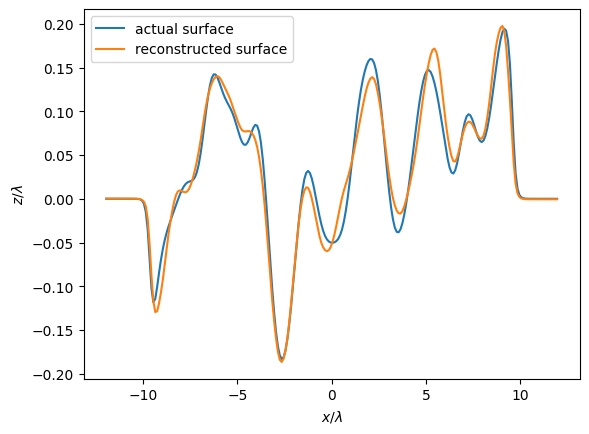

In [46]:
line1, = plt.plot(mesh_mid_obs[1:] / lamb, hei_actual_vec / lamb)
line2, = plt.plot(mesh_mid_obs[1:] / lamb, hei_pred_vec / lamb)
plt.xlabel(r'$x/{\lambda}$')
plt.ylabel(r'$z/{\lambda}$')
leg=plt.legend([line1, line2],
        ['actual surface',
        'reconstructed surface'], loc = "best")
plt.savefig("without_noise.png")
plt.show()

In [47]:
# calculate the l2 norm error
error_vec = hei_actual_vec - hei_pred_vec
print("l2 norm error is: ", np.linalg.norm(error_vec) / np.linalg.norm(hei_actual_vec))

l2 norm error is:  0.19839406


In [48]:
# save the hyperparameters
torch.save(model.state_dict(), 'model_parameters_dirichlet.pth')

test the method with noisy data

In [49]:
ntest = 19720

In [50]:
# original surface height
hei_actual_tensor = normalized_hei_tensors[ntest]
hei_actual = inverse_normalize_tensor(hei_actual_tensor, hmax, hmin)
hei_actual_vec = hei_actual.cpu().detach().numpy()

In [51]:
# input datas
zz_tensor_test = normalized_zz_tensors[ntest].to(device)
sc_real_tensor_test = normalized_phis_real_tensors[ntest].to(device)
sc_imag_tensor_test = normalized_phis_imag_tensors[ntest].to(device)

In [52]:
# add white noise to the scattered data
# noise level eps
eps = 0.1
# random numbers in [-1,1]
random_float = (torch.rand_like(sc_real_tensor_test) - 0.5) * 2
sc_real_tensor_noise = sc_real_tensor_test * (1 + eps * random_float)
sc_imag_tensor_noise = sc_imag_tensor_test * (1 + eps * random_float)
sc_input_tensor_noise = ((torch.cat((sc_real_tensor_noise, sc_imag_tensor_noise), dim=0)).unsqueeze(0)).unsqueeze(0)

In [53]:
# output data (predicted surface)
hei_pred_tensor_noise = model(zz_tensor_test, sc_input_tensor_noise, normalized_x_tensors.to(device))
hei_pred_noise = inverse_normalize_tensor(hei_pred_tensor_noise, hmax, hmin)
hei_pred_vec = (hei_pred_noise.cpu().detach().numpy()).squeeze(0)

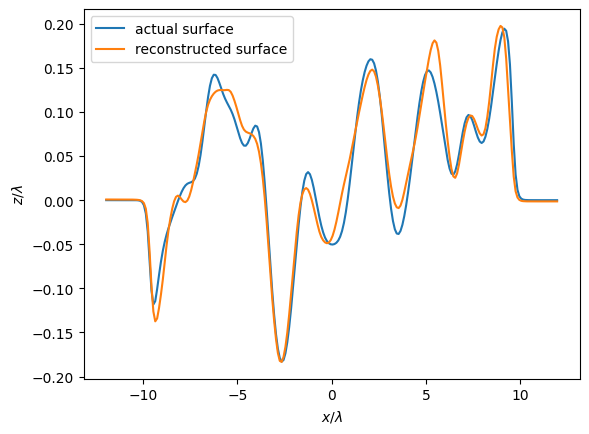

In [54]:
line1, = plt.plot(mesh_mid_obs[1:] / lamb, hei_actual_vec / lamb)
line2, = plt.plot(mesh_mid_obs[1:] / lamb, hei_pred_vec / lamb)
plt.xlabel(r'$x/{\lambda}$')
plt.ylabel(r'$z/{\lambda}$')
leg=plt.legend([line1, line2],
        ['actual surface',
        'reconstructed surface'], loc = "best")
plt.savefig("with_noise.png")
plt.show()

In [55]:
# calculate the l2 norm error
error_vec = hei_actual_vec - hei_pred_vec
print("l2 norm error is: ", np.linalg.norm(error_vec) / np.linalg.norm(hei_actual_vec))

l2 norm error is:  0.22391511
